In [1]:
# Gerekli kütüphaneleri tanımlıyoruz.

import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant

In [2]:
# Dataseti online kaynaktan okuyoruz. 
# Pandas kütüphanesi online csv dosyalarını okuyabiliyor
train_df = pd.read_csv("https://pjreddie.com/media/files/mnist_train.csv")
test_df = pd.read_csv("https://pjreddie.com/media/files/mnist_test.csv")

In [3]:
train_df.info()

# RangeIndex: 59999 entries, 0 to 59998 59999 data var
# Columns: 785 entries, 5 to 0.617 785 sütun var ilk sütun class label'ı gerki kalan 784 = 28*28 pixel sayısı

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59999 entries, 0 to 59998
Columns: 785 entries, 5 to 0.617
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
train_df.head()
# ilk 5 train satırı

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head()
# ilk 5 test satırı

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# eğitim için numpy dizisi haline getiriyoruz
y_train = np.array(train_df["5"].values).reshape(-1, 1)
x_train = np.array(train_df.drop(labels=["5"], axis = 1), dtype=np.uint8).reshape(-1, 784) / 255

y_test = np.array(test_df["7"].values).reshape(-1, 1)
x_test = np.array(test_df.drop(labels=["7"], axis = 1), dtype=np.uint8).reshape(-1, 784) / 255

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


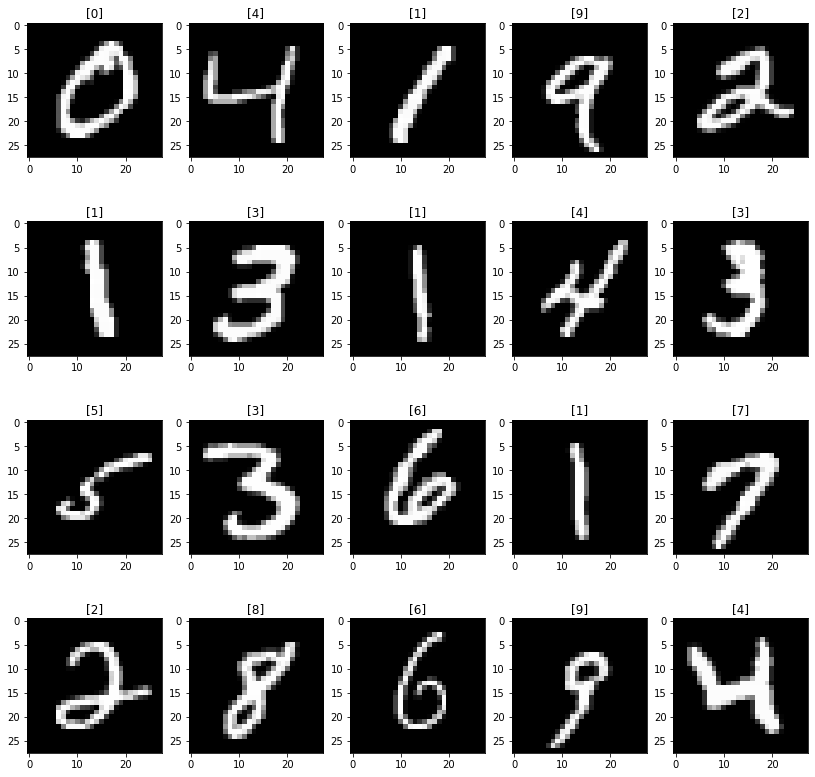

In [7]:
plt.figure(figsize=(14, 14))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
plt.show()

# datayı görselleştirmek ve anlamak adına çizdiriyoruz
# görüldüğü üzere data karmaşık geliyor, bu yüzden karıştırmamıza gerek yok


In [8]:
# RBF Katmanının Tanımlanması
# https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
      assert shape[1] == self.X.shape[1]
      idx = np.random.randint(self.X.shape[0], size=shape[0])

      # type checking to access elements of data correctly
      if type(self.X) == np.ndarray:
          return self.X[idx, :]
      elif type(self.X) == pd.core.frame.DataFrame:
          return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
# çoklu eğitimler için eğitim yapacağımız kod blogunu fonksiyon haline getiriyoruz

def train_rbf_network_with_configuration(configuration, verbose=0):
  global x_train, y_train, x_test, y_test

  model = tf.keras.Sequential()
  model.add(RBFLayer(configuration["InputLayerUnits"], # burası neuro sayısı,
                           initializer=InitCentersRandom(x_train),
                           betas=1.0,
                           input_shape=(784, )))
    
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

  model.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])
  
  train_timer = time.time()
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 256, epochs=configuration["Epoch"], verbose=verbose)
  configuration["training_duration"] = time.time() - train_timer

  print("----------------------")
  print(f"{configuration['Name']} Training Done! Training Took: {configuration['training_duration']}! Training Accuracy: {history.history['accuracy'][-1]}, Validation Accuracy: {history.history['val_accuracy'][-1]}")
  model.evaluate(x_test, y_test)
  print("----------------------")

  configuration["train_accuracy"] = history.history["accuracy"]
  configuration["val_accuracy"] = history.history["val_accuracy"]

In [10]:
# çoklu eğitimler için eğitim yapacağımız kod blogunu fonksiyon haline getiriyoruz


def train_neural_network_with_configuration(configuration, verbose=0):
  global x_train, y_train, x_test, y_test

  # keras modeli yaratılır
  model = tf.keras.Sequential()

  # modele girdi katmanı eklenir
  model.add(tf.keras.layers.Dense(configuration["InputLayerUnits"], input_shape=[784]))

  # eğer varsa gizli katmanlar eklenir
  for unit_size in configuration["HiddenLayers"]:
    model.add(tf.keras.layers.Dense(units=unit_size, activation=tf.nn.relu))

  # output katmanı eklenir
  model.add(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax))

  # model derlenir
  model.compile(optimizer='adam', # hiperpametre
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])
  
  train_timer = time.time()
  # model eğitilir
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 256, epochs=configuration["Epoch"], verbose=verbose)
  configuration["training_duration"] = time.time() - train_timer

  # evaluate ederken ne kadar sürüyor bunu görmek için
  print("----------------------")
  print(f"{configuration['Name']} Training Done! Training Took: {configuration['training_duration']}! Training Accuracy: {history.history['accuracy'][-1]}, Validation Accuracy: {history.history['val_accuracy'][-1]}")
  model.evaluate(x_test, y_test)
  print("----------------------")

  configuration["train_accuracy"] = history.history["accuracy"]
  configuration["val_accuracy"] = history.history["val_accuracy"]

In [11]:
# farklı özelliklerde model eğitmek için konfigürasyon listesi hazırlıyoruz
# bazılarında hidden layer fazla, bazılarında input layer unit sayısı fazla,
# doğru bir karşılaştırma adına epoch aynı

epoch = 200

ann_configurations = [
    {"Name": "MLP-1L-10", "InputLayerUnits": 10, "HiddenLayers": [], "Epoch": epoch},
    {"Name": "MLP-1L-100", "InputLayerUnits": 100, "HiddenLayers": [], "Epoch": epoch},
    {"Name": "MLP-1L-500", "InputLayerUnits": 500, "HiddenLayers": [], "Epoch": epoch},
    {"Name": "MLP-2L-500-1000", "InputLayerUnits": 500, "HiddenLayers": [1000], "Epoch": epoch},
    {"Name": "MLP-5L-2000", "InputLayerUnits": 500, "HiddenLayers": [1000, 2000, 1000, 500], "Epoch": epoch},
]

rbf_configurations = [
    {"Name": "RBF-10", "InputLayerUnits": 10, "Epoch": epoch},
    {"Name": "RBF-25", "InputLayerUnits": 25, "Epoch": epoch},
    {"Name": "RBF-50", "InputLayerUnits": 50, "Epoch": epoch},
    {"Name": "RBF-100", "InputLayerUnits": 100, "Epoch": epoch},
    {"Name": "RBF-200", "InputLayerUnits": 200, "Epoch": epoch},
]

In [12]:
for conf in rbf_configurations:
  train_rbf_network_with_configuration(conf)

----------------------
RBF-10 Training Done! Training Took: 171.4022023677826! Training Accuracy: 0.8924981951713562, Validation Accuracy: 0.8955895304679871
313/313 [==============================] - 1s 2ms/step - loss: 0.4055 - accuracy: 0.8956
----------------------
----------------------
RBF-25 Training Done! Training Took: 317.920907497406! Training Accuracy: 0.9098985195159912, Validation Accuracy: 0.9170917272567749
313/313 [==============================] - 1s 2ms/step - loss: 0.3055 - accuracy: 0.9171
----------------------
----------------------
RBF-50 Training Done! Training Took: 622.6766669750214! Training Accuracy: 0.9288321733474731, Validation Accuracy: 0.9299929738044739
313/313 [==============================] - 1s 2ms/step - loss: 0.2441 - accuracy: 0.9300
----------------------
----------------------
RBF-100 Training Done! Training Took: 1281.080109834671! Training Accuracy: 0.9429656863212585, Validation Accuracy: 0.9442944526672363
313/313 [=======================

In [13]:
for conf in ann_configurations:
  train_neural_network_with_configuration(conf)

----------------------
MLP-1L-10 Training Done! Training Took: 119.59049987792969! Training Accuracy: 0.939665675163269, Validation Accuracy: 0.9250925183296204
313/313 [==============================] - 1s 2ms/step - loss: 0.3015 - accuracy: 0.9251
----------------------
----------------------
MLP-1L-100 Training Done! Training Took: 129.19781136512756! Training Accuracy: 0.938448965549469, Validation Accuracy: 0.9240924119949341
313/313 [==============================] - 1s 2ms/step - loss: 0.3078 - accuracy: 0.9241
----------------------
----------------------
MLP-1L-500 Training Done! Training Took: 129.20430612564087! Training Accuracy: 0.9374322891235352, Validation Accuracy: 0.9214921593666077
313/313 [==============================] - 1s 2ms/step - loss: 0.3131 - accuracy: 0.9215
----------------------
----------------------
MLP-2L-500-1000 Training Done! Training Took: 142.53194880485535! Training Accuracy: 0.9990666508674622, Validation Accuracy: 0.9812981486320496
313/313 [=

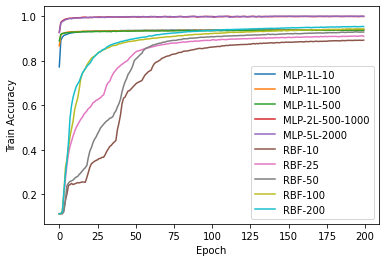

In [14]:
# eğitim sırasında her bir epoch sonunda hesaplanan train seti için accuracy değeri

plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")

for conf in ann_configurations:
    plt.plot([i for i in range(epoch)], conf["train_accuracy"], label=conf["Name"])

for conf in rbf_configurations:
    plt.plot([i for i in range(epoch)], conf["train_accuracy"], label=conf["Name"])

plt.legend()
plt.draw()
plt.show()

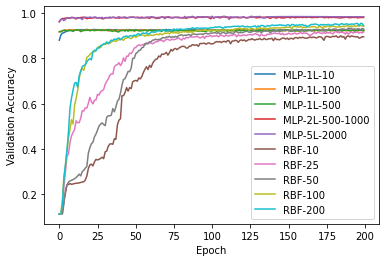

In [15]:
# eğitim sırasında her bir epoch sonunda hesaplanan test seti için accuracy değeri


plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

for conf in ann_configurations:
    plt.plot([i for i in range(epoch)], conf["val_accuracy"], label=conf["Name"])

for conf in rbf_configurations:
    plt.plot([i for i in range(epoch)], conf["val_accuracy"], label=conf["Name"])

plt.legend()
plt.draw()
plt.show()

Yukarıdaki çıktılar rapor üzerinde yorumlanmıştır.